In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed(1) 

In [2]:
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')


In [3]:
df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

In [4]:
for n in range(1,21):
    df['ret{}'.format(n)] = df['<OPEN>'].pct_change(periods = n).fillna(0)

In [5]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df_dummies_hour = pd.get_dummies(df['hour'], prefix = 'hour')
df_dummies_day = pd.get_dummies(df['day'], prefix = 'day')
df = df.join([df_dummies_hour,df_dummies_day])
df.drop(['hour','day'],inplace = True, axis = 1)

In [6]:
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0)

In [7]:
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"] #optional
df.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
X = df.drop(['retFut1'], axis=1)
y = df[['retFut1']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

In [9]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [10]:
def plot_corr(corr, size=5, title="Pearson correlation"):
    """Function plots a graphical correlation matrix dataframe 
    Input:
        df: pandas corr DataFrame from e.g. corr = df.corr(method='pierson')
        size: vertical and horizontal size of the plot
        title: title of the plot
    """

    fig, ax = plt.subplots(figsize = (size, size))
    #optionally, substitute the regular ax with an sns.heatmap (the regular ax has horrible colors)
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title(title)
    
    #plt.tight_layout() #optiona


In [11]:
non_uint = df.select_dtypes(exclude = ['uint8']).columns.values.tolist()
df_filtered = df[non_uint].fillna(0)

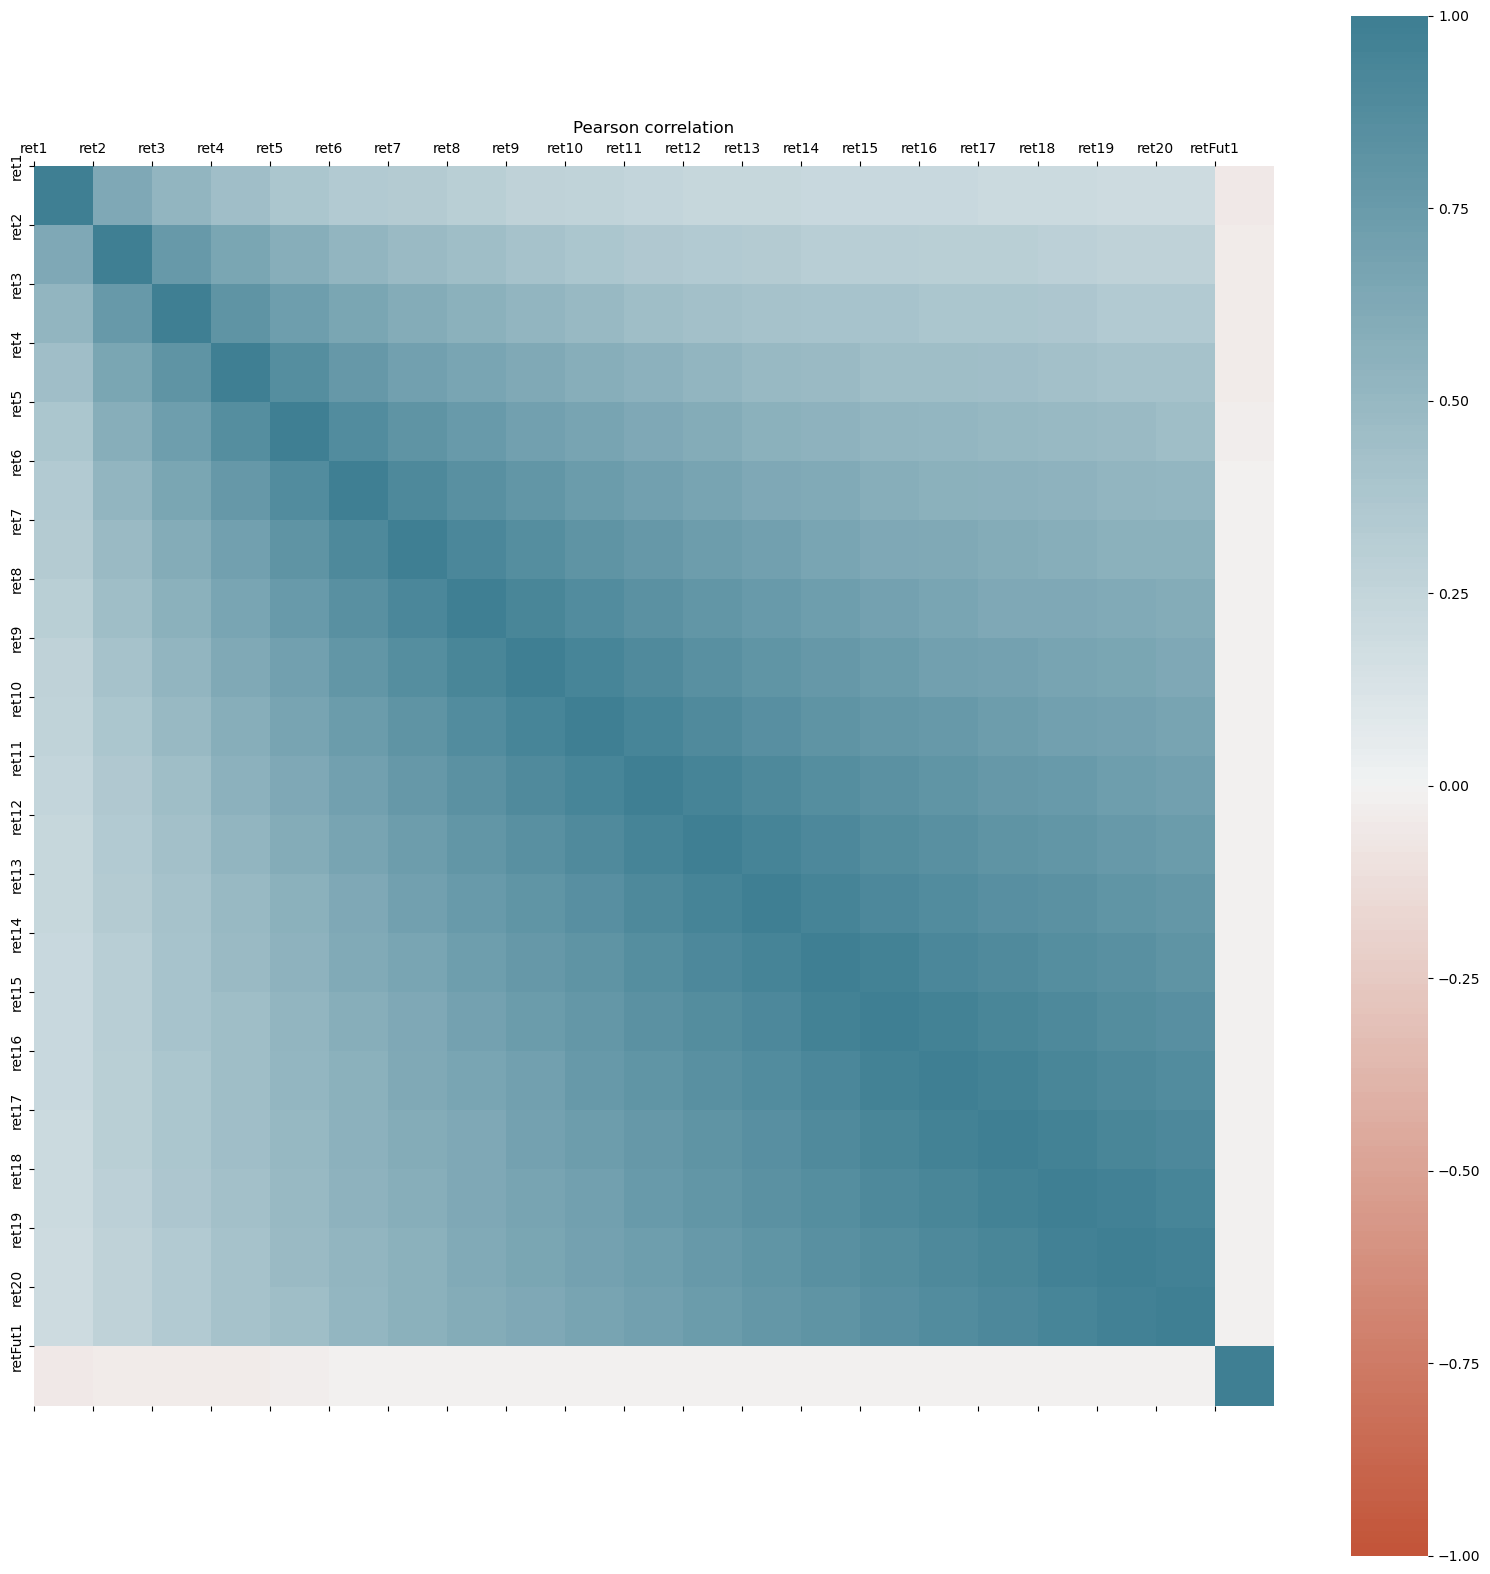

In [12]:
corr = df_filtered.corr(method='spearman').round(2)
plot_corr(corr, size=20)
#plt.show()
plt.savefig(r'Results\%s.png' %("Spearman Correlation Matrix"))

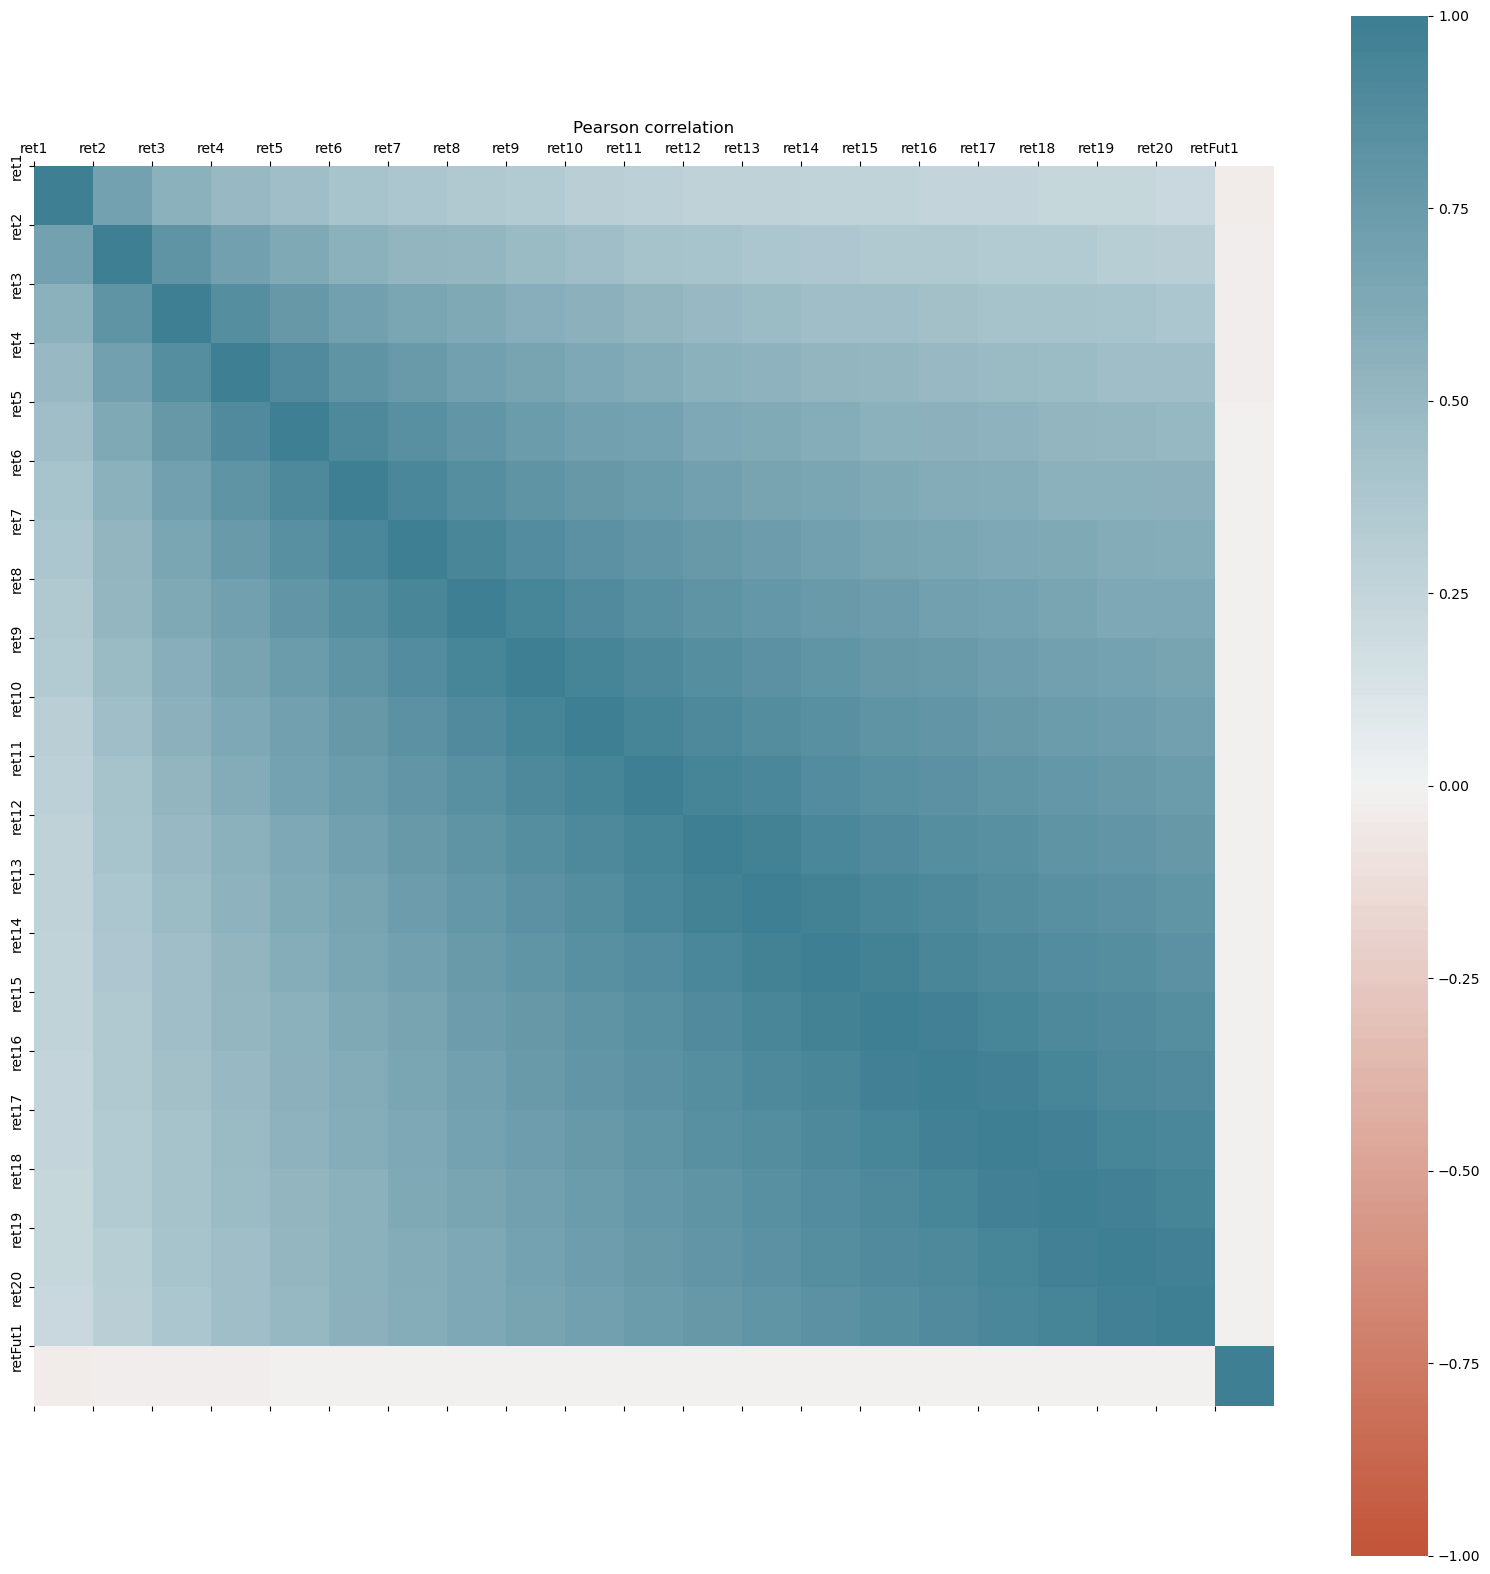

In [13]:
corr = df_filtered.corr(method='pearson').round(2)
plot_corr(corr, size=20)
#plt.show()
plt.savefig(r'Results\%s.png' %("Pearson Correlation Matrix"))

In [14]:
def calculate_pvalues(df, method='pearson'):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        if method=='pearson':
            for c in df.columns:
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
        else:
            for c in df.columns:
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)                
    return pvalues

In [15]:
print('pearson significance values')
print(calculate_pvalues(df_filtered, method='pearson'))
print('spearman significance values')
print(calculate_pvalues(df_filtered, method='spearman'))

pearson significance values
        ret1 ret2 ret3 ret4 ret5    ret6    ret7    ret8    ret9 ret10  ...  \
ret1     0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret2     0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret3     0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret4     0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret5     0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret6     0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret7     0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret8     0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret9     0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret10    0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret11    0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   0.0  ...   
ret12    0.0  0.0  0.0  

In [16]:
plt.close("all")


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
from sklearn.impute import SimpleImputer

In [18]:
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    print (rho)
    return rho


In [19]:
def sharpe(y_true, y_pred):
    positions = np.where(y_pred> 0,1,-1 )
    dailyRet = pd.Series(positions).shift(1).fillna(0).values * y_true
    dailyRet = np.nan_to_num(dailyRet)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
    return ratio

In [20]:
myscorerIC = make_scorer(information_coefficient)

In [21]:
imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
#we turn off scaling because ..
scaler = StandardScaler(with_mean=False, with_std=False)
ridge = Ridge(max_iter=1000) 

pipe = Pipeline([("imputer", imputer), ("scaler", scaler), ("ridge", ridge)])

In [22]:
a_rs = [1.00000000e-07, 2.33572147e-07, 5.45559478e-07, 1.27427499e-06,
       2.97635144e-06, 6.95192796e-06, 1.62377674e-05, 3.79269019e-05,
       8.85866790e-05, 2.06913808e-04, 4.83293024e-04, 1.12883789e-03,
       2.63665090e-03, 6.15848211e-03, 1.43844989e-02, 3.35981829e-02,
       7.84759970e-02, 1.83298071e-01, 4.28133240e-01, 1.00000000e+00]


param_grid =  [{'ridge__alpha': a_rs}]

In [23]:
grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorerIC, return_train_score=True) #####




In [24]:
grid_search.fit(x_train.values, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

0.07158026805801361
0.10059269755764162
0.035510503149579646
0.10654087963439293
0.0041924799149230165
0.11913314614161702
0.05766627964178844
0.11105862145256774
0.031356210315173785
0.12184959254107229
0.05440558682120979
0.09207945396516365
0.01578107589910454
0.09568544199590681
-0.009099398793227334
0.10838268966173721
0.03678956880629864
0.10138306984159696
0.04227538119004115
0.10552966731911582
0.07157226599876412
0.1005873722590723
0.03547177309423323
0.10654855501309808
0.0042053043168433476
0.11914221308076252
0.057662132847625384
0.11107843746494016
0.03143749222117205
0.12183720873511655
0.07132570522011779
0.10056952704786169
0.03525776439417141
0.10644399569139204
0.0031447265030346843
0.11914156171813753
0.0567907825678067
0.11124009965745266
0.03278555610093133
0.12195354520353867
0.07157690042786737
0.10059337414782889
0.03551046339875308
0.10653864698040584
0.004196785715930363
0.11913365809562433
0.05766606063945608
0.11105845403559553
0.031345876731774996
0.1218471

In [25]:
print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_ridgereg.csv")

Best parameters : {'ridge__alpha': 1.62377674e-05}
Best cross-validation score : 4.01


In [26]:
positions = np.where(grid_search.predict(x_train.values)> 0,1,-1 ) #POSITIONS

#dailyRet = fAux.backshift(1, positions) * x[:train_set,0] # x[:train_set,0] = ret1
dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1
dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

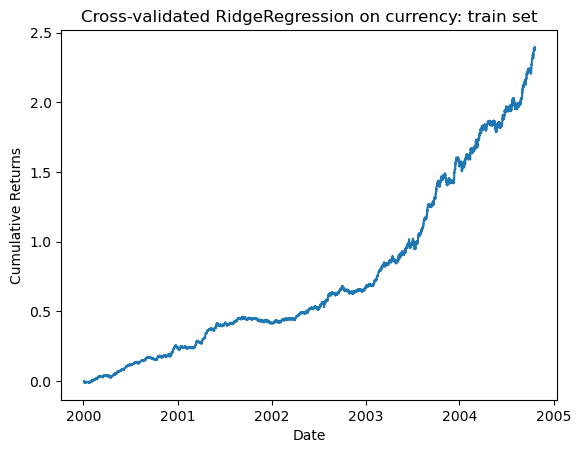

In [27]:
plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated RidgeRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))

In [28]:
cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))


In-sample: CAGR=0.031275 Sharpe ratio=1.22266 maxDD=-0.0383679 maxDDD=1181 Calmar ratio=0.815136



Text(0.5, 0, 'Date')

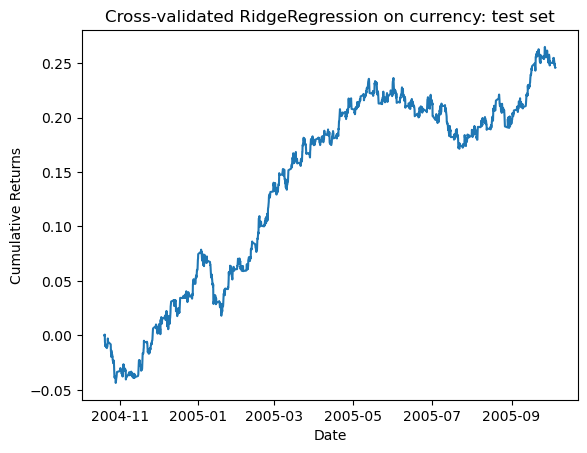

In [29]:
positions2 = np.where(grid_search.predict(x_test.values)> 0,1,-1 ) #POSITIONS


dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * x_test.ret1
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
plt.title('Cross-validated RidgeRegression on currency: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

In [30]:
plt.savefig(r'Results\%s.png' %("TestCumulative"))

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


Out-of-sample: CAGR=0.028077 Sharpe ratio=0.869825 maxDD=-0.0562483 maxDDD=609 Calmar ratio=0.499161  Rho=0.0979984 PVal=1.13114e-05



<Figure size 640x480 with 0 Axes>

In [31]:
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

In [32]:
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("Residuals"))
plt.close("all") 

In [33]:
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0,1])

Ljung-Box test p-value 0.0020549781377950955


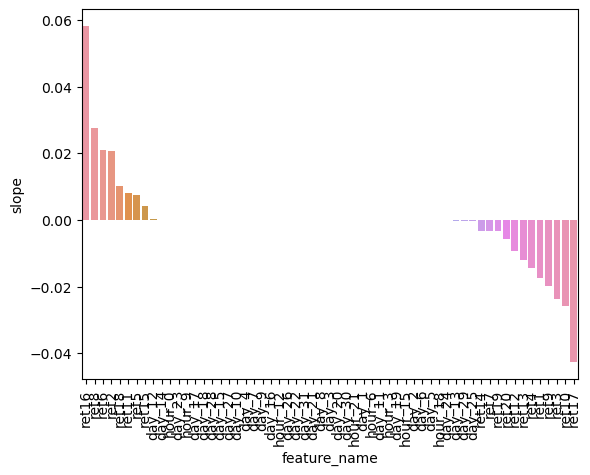

In [34]:
importance = pd.DataFrame(zip(best_model[2].coef_, x_train.columns.values.tolist()))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
#plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))
